<a href="https://colab.research.google.com/github/Loop3D/2022_iamg_workshop/blob/main/draw_your_own_GSSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing dependencies
This notebook will use two libraries from the Loop project
1. LoopStructural - https://github.com/Loop3D/LoopStructural
2. map2loop - https://github.com/Loop3D/map2loop-2


The following code blocks will install the required dependencies for the Loop libraries into this colab environment. Alternatively, the workshop can be run using the docker image.

## map2loop + LoopStructural

In [1]:
!pip install rasterio
!pip install git+https://github.com/geopandas/geopandas.git@v0.10.2
!pip install hjson
!pip install owslib
!pip install git+https://github.com/Loop3D/map2model_cpp.git
!pip install git+https://github.com/Loop3D/LoopProjectFile.git
!pip install pygeos
!pip install mplstereonet
!pip install lavavu-osmesa
!pip install LoopStructural
!pip install git+https://github.com/Loop3D/map2loop-2.git
!pip install beartype
!pip install git+https://github.com/giswqs/leafmap.git


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/geopandas/geopandas.git (to revision v0.10.2) to /tmp/pip-req-build-79tx3hvd
  Running command git clone -q https://github.com/geopandas/geopandas.git /tmp/pip-req-build-79tx3hvd
  Running command git checkout -q a65bda0a1ec25b99b02398865fd299852f7bac46
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/Loop3D/map2model_cpp.git to /tmp/pip-req-build-5e08_t4t
  Running command git clone -q https://github.com/Loop3D/map2model_cpp.git /tmp/pip-req-build-5e08_t4t
  Running command git submodule up

In [2]:

import leafmap
import pandas as pd
import json
import random
from shapely.geometry import Polygon
import ipywidgets as widgets
import geopandas as gpd
import os
import hjson
from map2loop.m2l_enums import VerboseLevel
from map2loop.project import Project
import random
from LoopStructural import GeologicalModel
from LoopStructural.visualisation import LavaVuModelViewer


In [3]:
center=(-32.8,138.8)

m =leafmap.Map( center=center, zoom=8,scroll_wheel_zoom=True)
m.add_basemap( basemap='OpenTopoMap')

m.add_wms_layer(url='https://www.loopwms.xyz/geoserver/SA/wms?',
    layers='flinders_geol',
    format='image/png',
    transparent=True,
    opacity=0.4,
    attribution='Geology data from GSSA',
    name='geology',
    shown=True)
aurl='https://www.loopwms.xyz/geoserver/SA/wms?'
m.add_wms_layer(url='https://www.loopwms.xyz/geoserver/SA/wms?',
#m.add_wms_layer(url='https://13.211.217.129:8080/geoserver/loop/wms?',
#    layers='2_5m_interpstrucl15_4326',
    layers='flinders_faults',
    format='image/png',
    transparent=True,
    opacity=0.4,
    attribution='Linear features data from GSSA',
    name='faults/folds')

m.add_wms_layer(url='https://www.loopwms.xyz/geoserver/SA/wms?',
    layers='flinders_structures',
    format='image/png',
    transparent=True,
    attribution='Outcrop data from GSSA',
    name='outcrops')

m

Map(center=[-32.8, 138.8], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

In [23]:

rect=m.draw_features

if(len(rect)==0): 
  minlong=138.68
  maxlong=139.05
  minlat= -33.23
  maxlat= -33.53

else:
  minlong=rect[0]['geometry']['coordinates'][0][0][0]
  maxlong=rect[0]['geometry']['coordinates'][0][2][0]
  minlat= rect[0]['geometry']['coordinates'][0][0][1]
  maxlat= rect[0]['geometry']['coordinates'][0][1][1]

In [24]:
src_crs = "epsg:4326"  # coordinate reference system for imported dtms (geodetic lat/long WGS84)
dst_crs = "epsg:28354" # coordinate system for example data


use_roi_clip=False
roi_clip_path=''
    

bounds=(minlong,maxlong,minlat,maxlat)


lat_point_list = [minlat, minlat, maxlat, maxlat,maxlat]
lon_point_list = [minlong, maxlong, maxlong, minlong, minlong]
bbox_geom = Polygon(zip(lon_point_list, lat_point_list))
mbbox = gpd.GeoDataFrame(index=[0], crs=src_crs, geometry=[bbox_geom]) 
bbox=mbbox.total_bounds
st_bbox=[bbox[0],bbox[1],bbox[2],bbox[3]]
print(src_crs,mbbox.total_bounds)
mbbox=mbbox.to_crs(dst_crs)
print(dst_crs,mbbox.total_bounds)

epsg:4326 [138.68 -33.53 139.05 -33.23]
epsg:28354 [ 283814.89475654 6287543.03762933  318921.64176603 6321518.43634233]


In [43]:
savepath=str(random.randint(1,10000))
proj = Project( 
                 loopdata_state = "SA",
            project_path=savepath,
    project_crs='EPSG:28354',
    verbose_level=VerboseLevel.NONE,
    working_projection='EPSG:28354',
    metadata_filename='./GSSA.json',

                )

proj.update_config(
                    out_dir=savepath,
                    bbox_3d={
                         "minx": mbbox.total_bounds[0], #500000,
                         "miny": mbbox.total_bounds[1], #7490000,
                         "maxx": mbbox.total_bounds[2], #545000,
                         "maxy": mbbox.total_bounds[3], #7520000,
                         "base": -4800,
                         "top": 1200,
                    },
                   run_flags={                        
                        'close_dip': -999,
                        'contact_decimate': 5,
                        'contact_dip': -999,
                        'contact_orientation_decimate': 5,
                        'deposits': "Fe,Cu,Au,NONE",
                        'dist_buffer': 10,
                        'dtb': '',
                        'fat_step': 750,
                        'fault_decimate': 5,
                        'fault_dip': 90,
                        'fold_decimate': 5,
                        'interpolation_scheme': 'scipy_rbf',
                        'interpolation_spacing': 500,
                        'intrusion_mode': 0,
                        'max_thickness_allowed': 10000,
                        'min_fault_length': 5000,
                        'misorientation': 30,
                        'null_scheme': 'null',
                        'orientation_decimate': 0,
                        'pluton_dip': 45,
                        'pluton_form': 'saucers',
                        'thickness_buffer': 5000,
                        'use_fat': False,
                        'use_interpolations': False,
                        'fault_orientation_clusters':2,
                        'fault_length_clusters':2,
                        'drift_prefix':['Q','T','water'],},
                    project_crs='EPSG:28354',

                  )



Warnings:
   -> No extra litho for geology polygons
   -> No more extra litho for geology polygons

Warnings:
   -> 2 NaN/blank found in column "inclinatio" of orientations file, replacing with 0
   -> 2 NaN/blank found in column "azimuth_tr" of orientations file, replacing with 0

Warnings:
   -> field named "id" added with default value
   -> No fault dip for fault polylines
   -> No fault dip direction for fault polylines
   -> No fault dip estimate for fault polylines
   -> No fault dip estimate text for fault polylines
   -> No fault name for fault polylines

Warnings:
   -> No fold polarity for fold polylines


In [44]:
proj.run()

  0%|          | 0/100 [00:00<?, ?it/s]


Warnings:
   -> 2 NaN/blank found in column "inclinatio" of orientations file, replacing with 0
   -> 2 NaN/blank found in column "azimuth_tr" of orientations file, replacing with 0


100%|██████████| 100/100 [00:35<00:00,  2.82it/s]


In [45]:
minx,miny,maxx,maxy = proj.config.bbox
model_base = proj.config.bbox_3d['base']
model_top = proj.config.bbox_3d['top']

In [46]:
f=open(proj.config.tmp_path+'/bbox.csv','w')
f.write('minx,miny,maxx,maxy,lower,upper\n')
ostr='{},{},{},{},{},{}\n'.format(minx,miny,maxx,maxy,model_base,model_top)
f.write(ostr)
f.close()

In [47]:
fault_params = {'interpolatortype':'FDI',
                'nelements':1e4,
                #'step':10,
                #'fault_buffer':0.2,

               }
foliation_params = {'interpolatortype':'FDI' , # 'interpolatortype':'PLI',
                    'nelements':1e5,  # how many tetras/voxels
                    #'buffer':2.,  # how much to extend nterpolation around box

                   }


model, m2l_data = GeologicalModel.from_map2loop_directory(proj.config.project_path,
                                                          evaluate=False,
                                                          fault_params=fault_params,
                                                          rescale=False,
                                                          foliation_params=foliation_params)

In [48]:
model.update()

  0%|          | 0/7 [00:00<?, ?it/s]

In [49]:
view = LavaVuModelViewer(model)
#view.add_model_surfaces()
view.nelements = 1e5
view.add_model_surfaces(faults=False)
view.nelements=1e6
view.add_model_surfaces(strati=False)

view.interactive()

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]


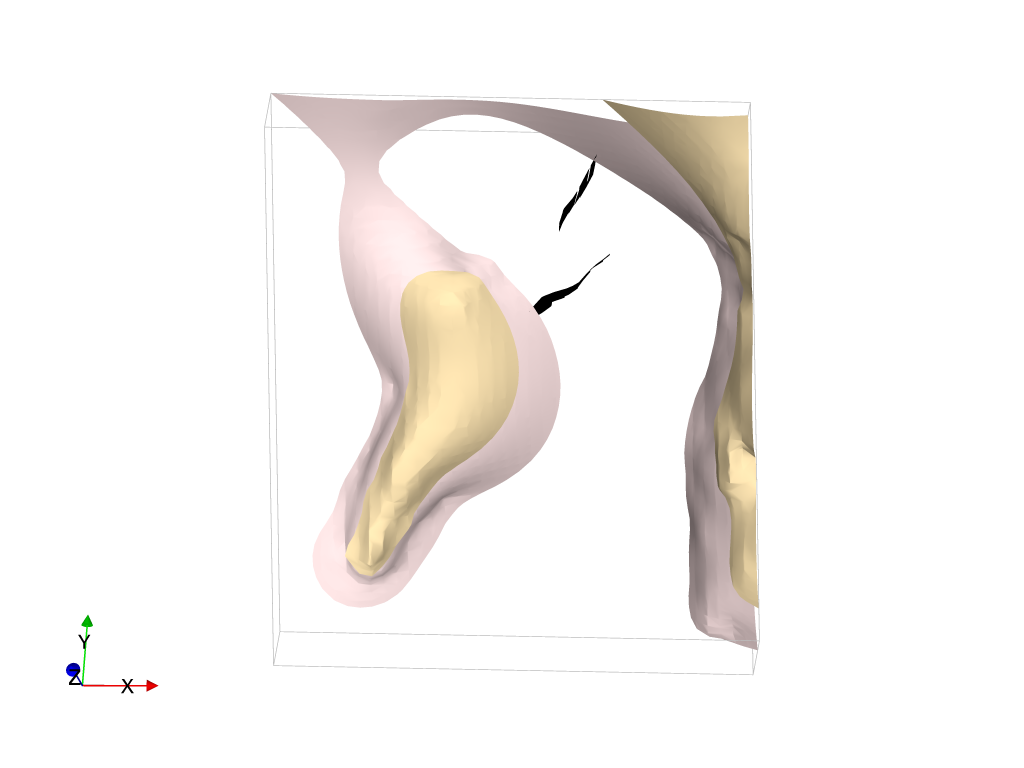

In [35]:
 view.display()

In [42]:
proj.config.tmp_path

'9469/tmp'